Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

ModuleNotFoundError: No module named 'watermark'

# Model Zoo -- CNN Gender Classifier (VGG16 Architecture, CelebA) with Data Parallelism

There are multiple ways of leveraging multiple GPUs when using PyTorch. One of these approaches is to send a copy of the model to each available GPU and split the minibatches across using `DataParallel`.

To break it down into conceptual steps, this is what `DataParallel` does 

1. each GPU performs a forward pass on a chunk of the minibatch (on a copy of the model) to obtain the predictions;
2. the first/default GPU gathers these predictions from all GPUs to compute the loss of each minibatch-chunk with respect to the true labels (this is done on the first/default GPU, because we typically define the loss, like `torch.nn.CrossEntropyLoss` outside the model);
3. each GPU then peforms backpropagation to compute the gradient of the loss on their-subbatch with respect to the neural network weights;
3. the first GPU sums up the gradients obtained from each GPU (computer engineers usually refer to this step as "reduce");
4. the first GPU updates the weights in the neural network via gradient descent and sends copies to the individual GPUs for the next round.

While the list above may look a bit complicated at first, the `DataParallel` class automatically takes care of it all, and it is very easy to use in practice.



### Data Parallelism vs regular Backpropagation

Note that using `DataParallel` will result in slightly different models compared to regular backpropagation. The reason is that via data parallelism, we combine the gradients from 4 individual forward and backward runs to update the model. In regular backprop, we would update the model after each minibatch. The following figure illustrates regular backpropagation showing 2 iterations:

![](../images/dataparallel/minibatch-update.png)

The next figure shows one model update iteration with `DataParallel` assuming 2 GPUs:

![](../images/dataparallel/minibatch-update-dataparallel.png)


### Implementation Details

To use `DataParallel`, in the "Model" section (i.e., the corresponding code cell) we replace

```python
model.to(device)
```

with 

```python
model = VGG16(num_features=num_features, num_classes=num_classes)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)
```

and let the `DataParallel` class take care of the rest. Note that in order for this to work, the data currently needs to be on the first cuda device, "cuda:0". Otherwise, we will get a `RuntimeError: all tensors must be on devices[0]`. Hence, we define `device` below, which we use to transfer the input data to during training. Hence, make sure you set 

```python
device = torch.device("cuda:0")
```

and not 

```python
device = torch.device("cuda:1")
```

(or any other CUDA device number), so that in the training loop, we can use

```python
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)
```

If you look at the implementation part


```python

#### DATA PARALLEL START ####

model = VGG16(num_features=num_features, num_classes=num_classes)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

#### DATA PARALLEL END ####
    
model.to(device)

#### DATA PARALLEL START ####


cost_fn = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
```

you notice that the `CrossEntropyLoss` (we could also use the one implemented in nn.functional) is not part of the model. Hence, the loss will be computed on the device where the target labels are, which is the default device (usually the first GPU). This is the reason why the outputs are gathered on the first/default GPU. I sketched a more detailed outline of the whole process below:

![](../images/dataparallel/dataparallel.png)

### Speed Comparison

- Using the same batch size as in the 1-GPU version of this code, means that if we have four GPUs, the 64-batch dataset gets split into four 16-batch sized datasets that will be distributed across the different GPUs. I noticed that the computation time is approximately half for 4 GPUs compared to 1 GPU (using GeForce 1080Ti cards).

- When I multiply the batch size by 4 in the `DataParallel` version, so that each GPU gets a minibatch of size 64, I notice that the model trains approximately 3x faster on 4 GPUs compared to the single GPU version.

### Network Architecture

The network in this notebook is an implementation of the VGG-16 [1] architecture on the CelebA face dataset [2] to train a gender classifier.  


References
    
- [1] Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.
- [2] Zhang, K., Tan, L., Li, Z., & Qiao, Y. (2016). Gender and smile classification using deep convolutional neural networks. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops (pp. 34-38).


The following table (taken from Simonyan & Zisserman referenced above) summarizes the VGG19 architecture:

![](../images/vgg16/vgg16-arch-table.png)

**Note that the CelebA images are 218 x 178, not 256 x 256. We resize to 128x128**

## Imports

In [67]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Dataset

### Downloading the Dataset

Note that the ~200,000 CelebA face image dataset is relatively large (~1.3 Gb). The download link provided below was provided by the author on the official CelebA website at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html. 

1) Download and unzip the file `img_align_celeba.zip`, which contains the images in jpeg format.

2) Download the `list_attr_celeba.txt` file, which contains the class labels

3) Download the `list_eval_partition.txt` file, which contains  training/validation/test partitioning info

### Preparing the Dataset

In [68]:
df1 = pd.read_csv('../celeba/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male'])

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0

df1.head()

,Male
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0


In [69]:
df2 = pd.read_csv('../celeba/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.head()

,Partition
Filename,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0


In [70]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.head()

,Male,Partition
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [71]:
df3.to_csv('celeba-gender-partitions.csv')
df4 = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df4.head()

,Male,Partition
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [72]:
df4.loc[df4['Partition'] == 0].to_csv('celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('celeba-gender-test.csv')

In [73]:
df4.loc[df4['Partition'] == 0].head()

,Male,Partition
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


(218, 178, 3)


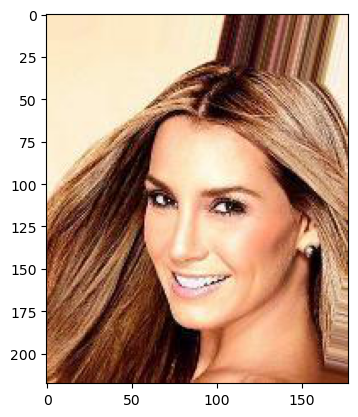

In [74]:
img = Image.open('../celeba/img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

### Implementing a Custom DataLoader Class

In [75]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

Running the VGG16 on this dataset with a minibatch size of 64 uses approximately 6.6 Gb of GPU memory. However, since we will split the batch size over for GPUs now, along with the model, we can actually comfortably use 64*4 as the batch size.

In [83]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',
                              img_dir='../celeba/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='celeba-gender-valid.csv',
                              img_dir='../celeba/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='celeba-gender-test.csv',
                             img_dir='../celeba/img_align_celeba/',
                             transform=custom_transform)

# BATCH_SIZE=64*torch.cuda.device_count()

BATCH_SIZE=128
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [77]:
for batch, (data, target) in enumerate(train_loader):
    if batch==15:
        print(data)
        print(target)
        break

tensor([[[[0.8549, 0.8549, 0.8549,  ..., 0.8039, 0.8039, 0.8078],
          [0.8471, 0.8471, 0.8471,  ..., 0.8078, 0.8078, 0.8157],
          [0.8431, 0.8431, 0.8471,  ..., 0.8078, 0.8078, 0.8157],
          ...,
          [0.5137, 0.4902, 0.6510,  ..., 0.2431, 0.1294, 0.2000],
          [0.5137, 0.4902, 0.6549,  ..., 0.3412, 0.2157, 0.2000],
          [0.5176, 0.4902, 0.6627,  ..., 0.4510, 0.3725, 0.2745]],

         [[0.8980, 0.8980, 0.8980,  ..., 0.8353, 0.8392, 0.8471],
          [0.8902, 0.8902, 0.8902,  ..., 0.8392, 0.8431, 0.8549],
          [0.8863, 0.8863, 0.8902,  ..., 0.8431, 0.8471, 0.8549],
          ...,
          [0.5608, 0.5373, 0.6980,  ..., 0.2431, 0.1294, 0.2000],
          [0.5608, 0.5373, 0.7020,  ..., 0.3412, 0.2157, 0.2000],
          [0.5647, 0.5373, 0.7098,  ..., 0.4510, 0.3725, 0.2745]],

         [[0.9059, 0.9059, 0.9059,  ..., 0.8431, 0.8431, 0.8510],
          [0.8980, 0.8980, 0.8980,  ..., 0.8471, 0.8510, 0.8588],
          [0.8941, 0.8941, 0.8980,  ..., 0

Note that for DataParallel to work, the data currently needs to be on the first cuda device, "cuda:0". Otherwise, we will get a `RuntimeError: all tensors must be on devices[0]`. Hence, we define `device` below, which we use to transfer the input data to during training.

In [78]:
#device = torch.device("cuda:0")
device=torch.device("cuda:1")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


## Model

In [79]:
##########################
### SETTINGS
##########################

# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 3

# Architecture
num_classes = 2

In [80]:
##########################
### MODEL
##########################


class VGG16(torch.nn.Module):

    def __init__(self,  num_classes):
        super(VGG16, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
        
        self.classifier = nn.Sequential(
                nn.Linear(512*4*4, 4096),
                nn.ReLU(),
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Linear(4096, num_classes)
        )
            
        
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                #n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                #m.weight.data.normal_(0, np.sqrt(2. / n))
                m.weight.detach().normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.detach().normal_(0, 0.05)
                m.bias.detach().detach().zero_()
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)

        logits = self.classifier(x.view(-1, 512*4*4))
        probas = F.softmax(logits, dim=1)

        return logits, probas

In [81]:
torch.manual_seed(random_seed)

#### DATA PARALLEL START ####

model = VGG16(num_classes=num_classes)
# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs")
#     model = nn.DataParallel(model)

#### DATA PARALLEL END ####
print(model)
model.to(device)

#### DATA PARALLEL START ####
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

VGG16(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


## Training

In [87]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader),
              compute_accuracy(model, valid_loader)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 1; 23.70 GiB total capacity; 1.67 GiB already allocated; 390.56 MiB free; 1.90 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Evaluation

In [16]:
model.eval()

with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 95.35%


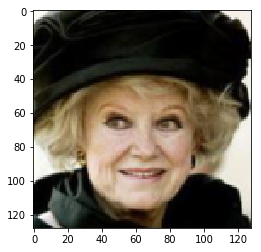

In [17]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [18]:
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 97.02%


In [19]:
%watermark -iv

numpy       1.15.4
pandas      0.23.4
torch       1.0.1.post2
PIL.Image   5.3.0

